In [0]:
import requests
import csv
import numpy as np
import pandas as pd
import random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data

In [0]:
data = pd.read_csv('/content/drive/My Drive/Study @ Fordham/NLP Project/nlp_finalproj_data_preprocessed.csv')

In [0]:
data['cuisine'].value_counts()

Middle Eastern    200
French            200
Mediterranean     200
Vietnamese        200
Chinese           200
Italian           200
African           123
Indian             99
Name: cuisine, dtype: int64

# Replace ingredient

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense,Flatten,Activation
from tensorflow.keras import Sequential 
import gensim 
from gensim.models import Word2Vec 

from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [0]:
# Ingredients of each recipe is a document
# Use all recipes as train dataset
# Skip-gram model
model_igd = gensim.models.Word2Vec(all_ingredients, min_count = 1, size = 100, window = 3, sg=1) 


# Some test
for igd in ['tomato', 'lemon juic', 'almond', 'sour cream', 'chili']:
    print(igd+" can be replaced by: ["+model_igd.wv.most_similar(positive=[igd], topn=1)[0][0]+"]\n")

tomato can be replaced by: [milk]

lemon juic can be replaced by: [juice of lemon]

almond can be replaced by: [allspic]

sour cream can be replaced by: [salt & pepp]

chili can be replaced by: [chicken]



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(9,9))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.0002, y+0.0002, word)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


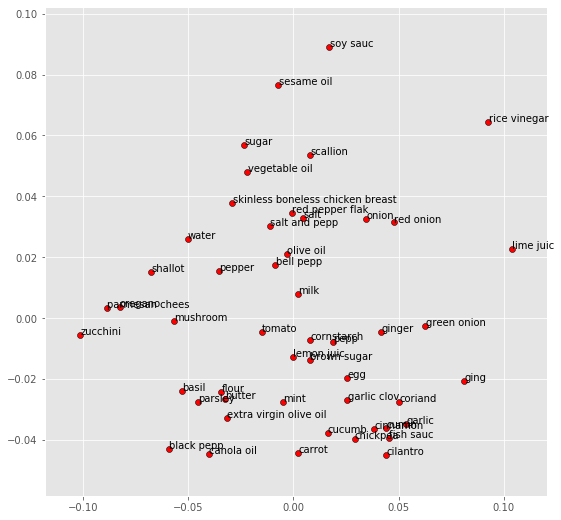

In [0]:
freq20 = model_igd.wv.index2entity[:50]
display_pca_scatterplot(model_igd, words=freq20)

# Similar Recipes

In [0]:
from gensim.models.doc2vec import TaggedDocument

def model_doc2vec(data):
    sentences= []
    for item_no, line in enumerate(data.values.tolist()):
        sentences.append(TaggedDocument(line,[item_no]))
    return sentences

In [0]:
# MODEL PARAMETERS
DM = 1     # 1 for distributed memory(default); 0 for DBOW
context_window = 5
SEED = 42
MIN_COUNT = 1

# BUILD MODELS
pi = model_doc2vec(data['process ingredients'])
ins =  model_doc2vec(data['instructions'])
model_pi = gensim.models.doc2vec.Doc2Vec(documents = pi, dm = DM, seed = SEED, min_count = MIN_COUNT)
model_ins = gensim.models.doc2vec.Doc2Vec(documents = ins, dm = DM, seed = SEED, min_count = MIN_COUNT)

In [0]:
# Do some test
TAEGET = 400  # ID of target recipe


new_vector = model_pi.infer_vector(data['process ingredients'][TAEGET])
similar_dishes = model_pi.docvecs.most_similar(positive=[new_vector], topn=5)
print("Similar dishes for:", data['title'][TAEGET], "(",data['cuisine'][TAEGET],")")
print("\n**** Based on process and ingredients ****")
for (n, similarity) in similar_dishes:
    print("--", data['cuisine'][n], "-",data['title'][n])


new_vector = model_ins.infer_vector(data['process ingredients'][TAEGET])
similar_dishes = model_ins.docvecs.most_similar(positive=[new_vector], topn=5)
print("\n**** Based on instructions ****")
for (n, similarity) in similar_dishes:
    print("--", data['cuisine'][n], "-",data['title'][n])


Similar dishes for: Grilled Ratatouille Salad ( French )

**** Based on process and ingredients ****
-- Chinese - Pork Fried Rice
-- French - Easy Freestyle Quiche
-- French - Meyer Lemon and Raspberry Crepes
-- French - French Lentil and Hominy Chili
-- African - African Chicken in Spicy Red Sauce

**** Based on instructions ****
-- Chinese - Pork Fried Rice
-- French - French Lentil and Hominy Chili
-- Italian - Cauliflower Crust Pizza
-- African - African Chicken in Spicy Red Sauce
-- African - Cape Malay Seafood Curry and a South African Food Safari at Gold Restaurant


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


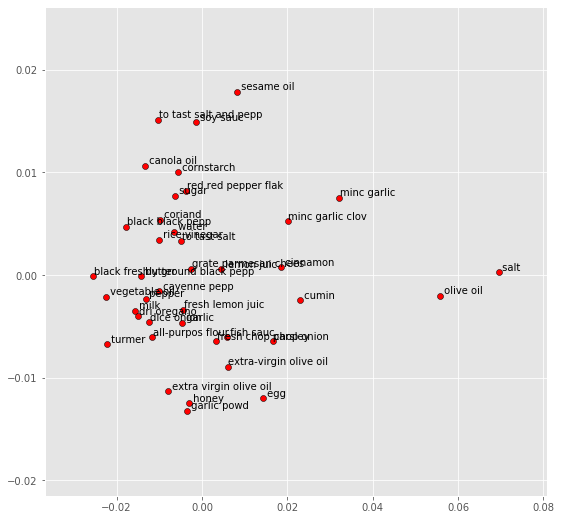

In [0]:
doc_freq20 = model_pi.wv.index2entity[:40]
display_pca_scatterplot(model_pi, words=doc_freq20)

In [0]:
# Find similar recipe but obey to certain recipe
def show_diets():
    print("The diets you can choose:")
    for d in diet_names:
        print("#", d)
    print("----------")

def find_recipe(similar_to, obey_diet = None):
    assert type(similar_to) == int
    assert type(obey_diet) in [None, str]
    print("...Searching for similar recipe to", data['title'][similar_to], "...")
    new_vector = model_ins.infer_vector(data['instructions'][similar_to])
    top20 = model_ins.docvecs.most_similar(positive=[new_vector], topn=20)
    if obey_diet != None:
        for (n, similarity) in top20:
            if data[str(obey_diet)][n] == 1:
                print("Must obey to following diets:", obey_diet)
                print("[Recommend recipe]:", data['cuisine'][n], "-",data['title'][n])
                return
            else:
                print("No recipe recommended.")
                return            

In [0]:
# Test

show_diets()
find_recipe(90, obey_diet = 'vegan')

The diets you can choose:
# no diet
# dairy fre
# fodmap friendli
# gluten fre
# ketogen
# lacto ovo vegetarian
# paleolith
# pescatarian
# primal
# vegan
# whole 30
----------
...Searching for similar recipe to Thai Vegan Fried Rice (Khao Phad Jay) ...
Must obey to following diets: vegan
[Recommend recipe]: Middle Eastern - Clean Eating Lentil Hummus


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
